In [1]:
# Load libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.integrate

In [2]:
################################# 
######## Define the model ######
#################################

# Return observable given parameter
def observable_1(x,y):
    
    result=(3-x)*(y+1)                            #<=========================================================
    
    return result

# Return observable given parameter
def observable_2(x,y):
    
    result=(x*x+1)*(y+1)*(np.log(1+y*y))          #<=========================================================
    
    return result

# Define the allowed range of values of the parameter "x" and "y"
xmin=0;                             #<=========================================================
xmax=2;                             #<=========================================================
ymin=0;                             #<=========================================================
ymax=5;                             #<=========================================================

In [3]:
#########################
#### Get the "data" #####
#########################

# Value of the parameters "x" we want to constrain with the Bayesian analysis
x_truth=0.4;                       #<=========================================================
y_truth=1.5;                       #<=========================================================

# This will be a "closure test": we use the model to generate "data"
# The Bayesian parameter estimation should be peaked around "x_truth"
data_mean_1=observable_1(x_truth,y_truth)
data_mean_2=observable_2(x_truth,y_truth)

# Real data come with uncertainties
# Here, we just define an arbitrary uncertainty on the "data"
relative_uncertainty_1=.1                         #<=========================================================
data_uncert_1=relative_uncertainty_1*data_mean_1
relative_uncertainty_2=.1                         #<=========================================================
data_uncert_2=relative_uncertainty_2*data_mean_2

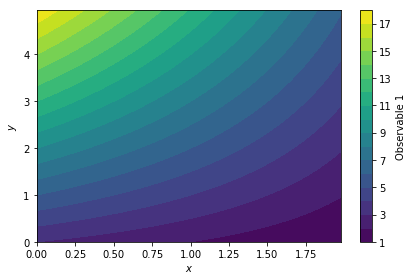

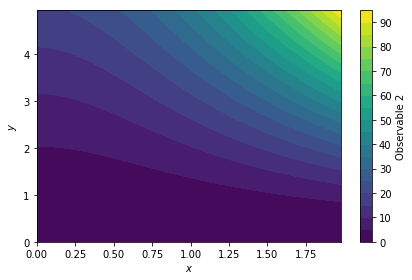

In [10]:
#########################
#### Plot the "data" #####
#########################

for obs_fct, obs_label, data_mean, data_uncert in [(observable_1, "Observable 1", data_mean_1, data_uncert_1), (observable_2, "Observable 2", data_mean_2, data_uncert_2)]:

    # Plot what the observable looks like over the parameter prior
    plt.figure()
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')

    # Compute the posterior for a range of values of the parameter "x"
    x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
    y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

    x_mesh, y_mesh =  np.meshgrid(x_range, y_range, sparse=False, indexing='ij')

    z_list = obs_fct(x_mesh,y_mesh)

    # Plot the posterior
    cs = plt.contourf(x_mesh, y_mesh, z_list, 20)

    cbar = plt.colorbar(cs,label=obs_label) 

    # Plot the "data"
    #plt.contour(x_mesh, y_mesh, z_list, levels=[data_mean],colors='grey')
    #cs3 = plt.contourf(x_mesh, y_mesh, z_list, levels=[data_mean-data_uncert,data_mean+data_uncert],colors='white',alpha=.4)

    plt.tight_layout()
    plt.show()

In [5]:
########################
# Get the calculations #
########################

# Number of points used for the "emulator"
number_design_emulator=20                #<=========================================================

# For simplicity, we sample the emulator uniformly
x_list=np.linspace(xmin,xmax,num=number_design_emulator)
y_list=np.linspace(ymin,ymax,num=number_design_emulator)

x_mesh, y_mesh =  np.meshgrid(x_list, y_list, sparse=False, indexing='ij')

calculation_mean_list_1=observable_1(x_mesh,y_mesh)
calculation_mean_list_2=observable_2(x_mesh,y_mesh)

# Model calculations typically have some uncertainties as well
relative_uncertainty_1=0.03                                         #<============================================
calculation_uncert_list_1=relative_uncertainty_1*calculation_mean_list_1
relative_uncertainty_2=0.03                                         #<============================================
calculation_uncert_list_2=relative_uncertainty_2*calculation_mean_list_2

In [6]:
#########################################
# Make interpolator for each observable #
#########################################

emulator_calc_1=scipy.interpolate.interp2d(x_list, y_list, calculation_mean_list_1.T, kind='linear', copy=True, bounds_error=False, fill_value=None)
emulator_uncert_1=scipy.interpolate.interp2d(x_list, y_list, calculation_uncert_list_1.T, kind='linear', copy=True, bounds_error=False, fill_value=None)
emulator_calc_2=scipy.interpolate.interp2d(x_list, y_list, calculation_mean_list_2.T, kind='linear', copy=True, bounds_error=False, fill_value=None)
emulator_uncert_2=scipy.interpolate.interp2d(x_list, y_list, calculation_uncert_list_2.T, kind='linear', copy=True, bounds_error=False, fill_value=None)

# Does the emulator work?
x_test=xmin+0.2*(xmax-xmin)                     #<=========================================================
y_test=ymin+0.6*(ymax-ymin)                     #<=========================================================
print(observable_1(x_test,y_test))
print(emulator_calc_1(x_test,y_test))
print(observable_2(x_test,y_test))
print(emulator_calc_2(x_test,y_test))

10.4
[10.4]
10.683994831492374
[10.70569982]


In [7]:
#########################
# Compute the posterior #
#########################

# We assume uniform priors for this example
# Here 'x' is the only model parameter
def prior(x,y):
    
    return 1


# Under the approximations that we're using, the posterior is
# exp(-1/2*\sum_{observables, pT} (model(observable,pT)-data(observable,pT))^2/(model_err(observable,pT)^2+exp_err(observable,pT)^2)

# Here 'x' is the only model parameter
def likelihood(x,y):

    res=0.0
    
    norm=1.

    # Sum over observables
    for emulator_calc, emulator_uncert, data_mean, data_uncert in [(emulator_calc_1, emulator_uncert_1, data_mean_1, data_uncert_1),(emulator_calc_2, emulator_uncert_2, data_mean_2, data_uncert_2)]:
    
        # Vectorize the emulators
        emulator_calc_vec = np.vectorize(emulator_calc)
        emulator_uncert_vec = np.vectorize(emulator_uncert)

        tmp_model_mean=emulator_calc_vec(x,y)
        tmp_model_uncert=emulator_uncert_vec(x,y)

        tmp_data_mean=data_mean
        tmp_data_uncert=data_uncert

        cov=(tmp_model_uncert*tmp_model_uncert+tmp_data_uncert*tmp_data_uncert)

        res+=np.power(tmp_model_mean-tmp_data_mean,2)/cov
        
        norm*=1/np.sqrt(cov)

    res*=-0.5
    
    return norm*np.exp(res)


#
def posterior(x,y):
    
    return prior(x,y)*likelihood(x,y)


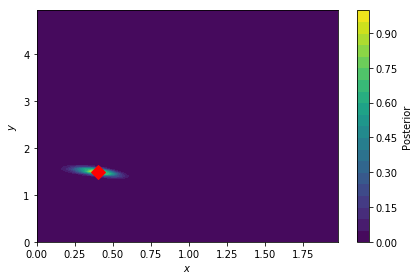

In [8]:
##################
# Plot posterior #
##################

plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)
y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

x_mesh, y_mesh =  np.meshgrid(x_range, y_range, sparse=False, indexing='ij')

posterior_array = posterior(x_mesh,y_mesh)

# Plot the posterior
cs = plt.contourf(x_mesh, y_mesh, posterior_array, 20)

cbar = plt.colorbar(cs,label="Posterior") 

plt.plot([x_truth], [y_truth],"D",color='red',ms=10)

plt.tight_layout()
plt.show()

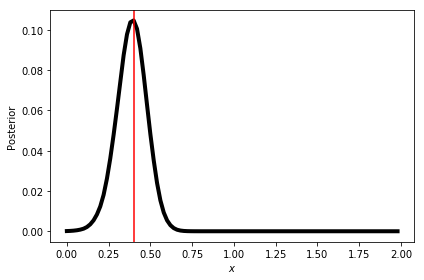

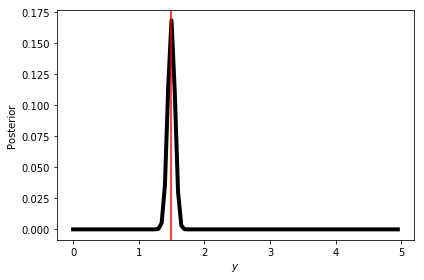

In [9]:
###############################
# Plotting marginal posterior #
###############################

# Posterior vs x
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$x$')
plt.ylabel(r'Posterior')

# The marginal posterior for a parameter is obtained by integrating over a subset of other model parameters

# Compute the posterior for a range of values of the parameter "x"
x_range=np.arange(xmin, xmax, (xmax-xmin)/100.)

posterior_list = [ scipy.integrate.quad(lambda y_val: posterior(x_val,y_val),ymin,ymax)[0] for x_val in x_range ]

plt.plot(x_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=x_truth,color='red')

plt.tight_layout()
plt.show()


# Posterior vs y
plt.figure()
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel(r'$y$')
plt.ylabel(r'Posterior')

# Compute the posterior for a range of values of the parameter "x"
y_range=np.arange(ymin, ymax, (ymax-ymin)/100.)

posterior_list = [ scipy.integrate.quad(lambda x_val: posterior(x_val,y_val),xmin,xmax,limit=100, epsrel=1e-4)[0] for y_val in y_range ]

plt.plot(y_range, posterior_list, "-", color='black', lw=4)

plt.axvline(x=y_truth,color='red')

plt.tight_layout()
plt.show()
